# Abstract

In this notebook, we perform a basic machine learning (ML) based analysis of the toy dataset of one cancer biopsy sample provided by Yuchen, which consists of optical reference images of the sample (of varying resolutions) and the pixel-based Mass Spectrometry Imaging (MSI) spectral data of the sample. Herein, we will begin by performing a preliminary analysis including data visualisation and feature selection, and proceed to conduct a more in-depth analysis, aiming to perform image segmentation. We will implement both supervised and unsupervised learning approaches and will use a combination of these methods to thoroughly analyse the sample.

# Section 1: Setup

We will begin by importing some of the core libraries that we will be using throughout our analysis.

In [1]:
import numpy as np
import scipy as sp
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.image as mpimg
import sklearn 
import pyimzml
import os
print('Imports complete')

ModuleNotFoundError: No module named 'pyimzml'

We define a function to set the current working directory for this notebook. This is only an auxiliary function, and serves no other purpose.

In [2]:
def set_wd(path):
    """
    Sets the working directory of the notebook to the specified path.
    
    Parameters:
        path (str): The path to set as the working directory.
    
    Returns:
        Updated working directory (str)

    Raises:
        FileNotFoundError: Raised if the specified path does not exist
    """
    if os.path.exists(path):
        os.chdir(path)
        cwd = os.getcwd()
        print(f'Working directory updated to: {cwd}')
        return cwd
    else:
        raise FileNotFoundError(f"The specified working directory {path} does not exist.")

path = "/home/fs1620/MLBD_2024_25/Research_Project/YuchenToyDataset/DESI_Example"
try:
    set_wd(path)
except FileNotFoundError as e:
    print(e)

Working directory updated to: /home/fs1620/MLBD_2024_25/Research_Project/YuchenToyDataset/DESI_Example


# Section 2: Data in the *.mat* File
Now we can start reading in some of the data. It is important to note that the `.mat` file provided by Yuchen needs to be loaded using the `h5py` library. This is because newer MATLAB versions (v7.3 or later) save `.mat` files in the HDF5 format, which is not supported by `scipy.io`. Instead, `scipy.io` is compatible with older MATLAB versions (v7.2 or earlier) that use the simpler MATLAB binary format.

This means, the following should not work:

In [3]:
from scipy.io import loadmat

try:
    data_matlab = loadmat('Yuchen_A30.mat')
except NotImplementedError as e:
    print(e)

Please use HDF reader for matlab v7.3 files, e.g. h5py


which is what we expect.

However, the following cell should load in the data properly:

#refs# is a group. Exploring group #refs#...

Subkey: a
Data in #refs#, a:
[0 0]
Shape of data: (2,)
Subkey: b
Data in #refs#, b:
[[ 84]
 [117]
 [109]
 [111]
 [117]
 [114]]
Shape of data: (6, 1)
Decoded: Tumour
Subkey: c
Data in #refs#, c:
[[ 84]
 [117]
 [109]
 [111]
 [117]
 [114]
 [ 32]
 [ 97]
 [115]
 [115]
 [111]
 [ 99]
 [105]
 [ 97]
 [116]
 [101]
 [100]
 [ 32]
 [109]
 [117]
 [115]
 [ 99]
 [108]
 [101]]
Shape of data: (24, 1)
Decoded: Tumour associated muscle
Subkey: d
Data in #refs#, d:
[[ 84]
 [117]
 [109]
 [111]
 [117]
 [114]
 [ 32]
 [ 97]
 [115]
 [115]
 [111]
 [ 99]
 [105]
 [ 97]
 [116]
 [101]
 [100]
 [ 32]
 [115]
 [116]
 [114]
 [111]
 [109]
 [ 97]]
Shape of data: (24, 1)
Decoded: Tumour associated stroma
Subkey: e
Data in #refs#, e:
[[ 66]
 [ 97]
 [ 99]
 [107]
 [103]
 [114]
 [111]
 [117]
 [110]
 [100]]
Shape of data: (10, 1)
Decoded: Background
Key: img
Data in img:
[[[228 228 229 ... 236 235 236]
  [237 238 239 ... 237 236 236]
  [236 237 238 ... 236 236 236]
  ...
  [236 237 2

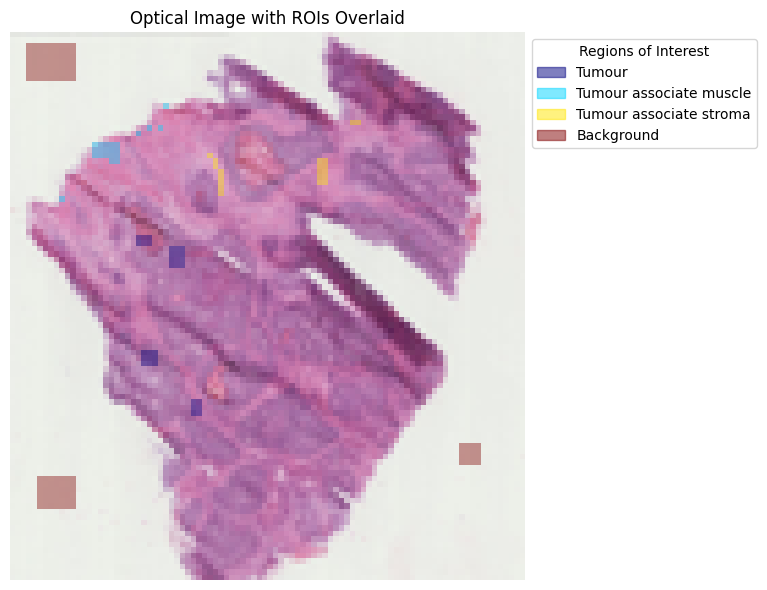

In [4]:
with h5py.File('Yuchen_A30.mat', 'r') as f:
    def decode_ascii(data):
        """Decode ASCII-encoded data if possible."""
        try:
            return ''.join([chr(x[0]) for x in data])
        except Exception as e:
            return None  # Return None if decoding fails

    for key in f.keys():
        # Check if the key corresponds to a dataset
        if isinstance(f[key], h5py.Dataset):
            print(f"Key: {key}")
            data = f[key][:]
            # Attempt to decode as ASCII if applicable
            decoded = decode_ascii(f[key])
            if decoded:
                print(f"Decoded: {decoded}")
            print(f"Data in {key}:")
            print(data)
            print(f"Shape of data: {data.shape}\n")

            # Used for plotting later
            if key == 'img':
                img = data  # Optical image data
            elif key == 'rois':
                print(f'Unique regions in image: {np.unique(f['rois'])}')
                rois = data  # ROI data
                np.save('rois.npy', rois)  # Save ROI data as NumPy array; more on this later
                
            if key == 'labs':
                labs_data = data  # Data containing HDF5 object references
                print(f"Data in labs (references): {labs_data}")
                # Dereference the object references in labs
                dereferenced_labs = []
                labels = []  # List to store the decoded labels
                for ref in labs_data.flat:  # Flattening the array to loop over all references
                    deref_obj = f[ref]  # Dereference the object using the reference
                    dereferenced_labs.append(deref_obj)
                    decoded_label = decode_ascii(deref_obj)
                    labels.append(decoded_label)  # Append the label to the list
                    print(f"Dereferenced object: {deref_obj}")
                    print(f"Shape of dereferenced object: {deref_obj.shape if isinstance(deref_obj, h5py.Dataset) else 'N/A'}\n")

        # If it corresponds to a group, explore its subkeys
        elif isinstance(f[key], h5py.Group):
            print(f"{key} is a group. Exploring group {key}...\n")
            for subkey in f[key].keys():
                if isinstance(f[key][subkey], h5py.Dataset):
                    print(f"Subkey: {subkey}")
                    subdata = f[key][subkey][:]
                    print(f"Data in {key}, {subkey}:")
                    print(subdata)
                    print(f"Shape of data: {subdata.shape}")
                    # Attempt to decode as ASCII if applicable
                    decoded = decode_ascii(f[key][subkey])
                    if decoded:
                        print(f"Decoded: {decoded}")

    if 'img' in locals() and 'rois' in locals():
        fig, ax = plt.subplots(figsize=(8, 6))
    
        # Plot the RGB image
        ax.imshow(np.transpose(img, (1, 2, 0)), cmap='gray')  # Transpose to (height, width, channels)
        
        # Mask the non-region values in the ROIs array where rois array == 0
        masked_rois = np.ma.masked_equal(rois, 0)
    
        # Overlay ROIs with the mask applied, using a distinguishablecolourmap for better region differentiation
        overlay = ax.imshow(masked_rois, cmap='jet', alpha=0.4)  # Use 'jet' for distinct colours; adjust alpha for aesthetics
    
        # Extract the colourmap used for the overlay
        cmap = plt.colormaps['jet']  # Use a distinguishable colourmap
        norm = plt.Normalize(vmin=np.min(rois[rois > 0]), vmax=np.max(rois[rois > 0]))  # Normalize using non-zero values
    
        # Get a list of colours used in the overlay, one for each unique region (excluding 0)
        colors = [cmap(norm(i)) for i in np.unique(rois)[1:]]  # Skip '0'; it is a non-region
        regions = ['Tumour', 'Tumour associate muscle', 'Tumour associate stroma', 'Background']
    
        # Create patches with alpha for the legend to match the overlay alpha
        patches = [mpatches.Patch(color=color, label=f"{region}", alpha=0.5) for color, region in zip(colors, regions)] # adjust alpha for aesthetics
    
        # Add the legend with the custom alpha, positioning it outside the figure
        ax.legend(handles=patches, title="Regions of Interest", loc='upper left', bbox_to_anchor=(1, 1))
        # Title and display settings
        plt.title("Optical Image with ROIs Overlaid")
        plt.axis('off')
    
        # Adjust layout to prevent clipping of the legend
        plt.tight_layout()
    
        # Save and show the plot
        plt.savefig('SampleImageLabelOverlay.png', dpi=300, bbox_inches='tight')
        plt.show()  
    else:
        print("Image or ROI data not found.")

The `.mat` file contains a variety of data, including both structured and abstract information as shown in the output above. Initially, we wrote some simple code to load and inspect the data. Later, using the insight gained by inspection, we modified the code to allow us to probe into the contents of the file. We will now discuss what this information represents.

The keys within the `.mat` file can refer to two main types of data structures: **groups** and **datasets**.

- **Groups**: These are collections of related datasets and are analogous to folders in a file system. Groups may contain additional groups (subgroups) or datasets as their contents.

- **Datasets**: These represent actual data values, such as arrays, matrices, or numerical data, stored in the file. Datasets can also include references to other objects within the file, such as other datasets or groups.

We have ensured to distinguish between these and accessed these accordingly. We have included a function to decode any ASCII-encoded text that may be present in the file.

We find the following keys in the file:
- `#refs#`: This is a group, and the subkeys of this group refer to ASCII-encoded data, which provide the following labels for the optical image of the sample (more on this in the next point): **Tumour**, **Tumour associated muscle**, **Tumour associated stroma**, **Background**.
- `img`: This is a dataset that contains an array representing the optical image of the sample. The shape of this dataset is (3, 100, 94). The 3 represents the number of channels of colour (Red, Blue, Green), 100 refers to the image height in pixels (# rows), and 94 refers to the image width in pixels (# columns). In short, we have an image with 100 rows and 94 columns, where each pixel contains three values corresponding to its Red, Green, and Blue intensity levels.
- `labs`: This is a dataset that contains references to other datasets. The labs key points to a list of references to four datasets (`b`, `c`, `d`, `e`). These datasets contain numerical data and are dereferenced as follows:
    - `b`: This dataset has a shape of (6, 1) and contains values of type "<u2" (unsigned 16-bit integers). Corresponds to label **Tumour**.
    - `c`: This dataset has a shape of (24, 1) and contains values of type "<u2". Corresponds to label **Tumour associated muscle**.
    - `d`: This dataset, like c, has a shape of (24, 1) and contains values of type "<u2". Corresponds to label **Tumour associated stroma**.
    - `e`: This dataset has a shape of (10, 1) and contains values of type "<u2". Corresponds to label **Background**.

    
- `rois`: This is a dataset containing an array that functions as a mask for the optical image, identifying **regions of interest (ROIs)** in the image. The array contains five unique values: [0, 1, 2, 3, 4], with the non-zero values corresponding to the actual regions of interest: **Tumour**, **Tumour associated muscle**, **Tumour associated stroma**, and **Background**. The 0s represent non-regions and do not refer to any specific area of interest in the image.

Putting all the datasets together, we have used the data in the `img` dataset to reproduce the optical image of the sample, and overlayed the ROIs on this image using the data in the `rois` dataset. We have excluded the non-regions from the overlay. The steps for this process are carefully detailed in the cell above. As a stylistic choice we have chosen to invert the x-axis of the plot.

# Section 3: Data in the *.imzML* and *.ibd* Files
Now, we proceed to load the other files.

The remaining files are in the `.ibd` and `.imzML` formats. These two formats are interconnected and designed to be used together. Simply put:

- The `.ibd` file contains the raw binary spectral data, such as intensities and related information. However, this binary data is challenging to interpret without expert knowledge of its structure and meaning.
- The `.imzML` file serves as a metadata and index file that describes the structure and contents of the `.ibd` file, mapping coordinates, spectral indices, and other details to the raw data.

Since the `.imzML` file provides all the information required to interpret the `.ibd` file, we only need to read the `.imzML` file to extract meaningful data.

Rather than printing all the data (which could be extensive), we will summarise key aspects, such as:
- The number of coordinates,
- The number of m/z values,
- A preview of the first few spectra, to get a sense of the data's structure and characteristics.

/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: Use

Spectra collected at a total of: 8836 coordinates

Unique x-coordinates: 94
Unique y-coordinates: 94
Unique z-coordinates: 1

The first spectrum contains 398 m/z values, ranging from 200.94 to 996.81.
Shapes of arrays. mz_values: (398,) (398,)

Preview of the first few spectra:
  Spectrum 1: Coordinates (1, 1, 1), Number of m/z values: 398, Total intensity: 28009.711, Mean intensity: 70.376
  Spectrum 2: Coordinates (2, 1, 1), Number of m/z values: 375, Total intensity: 28836.320, Mean intensity: 76.897
  Spectrum 3: Coordinates (3, 1, 1), Number of m/z values: 380, Total intensity: 29116.359, Mean intensity: 76.622
  Spectrum 4: Coordinates (4, 1, 1), Number of m/z values: 471, Total intensity: 32387.178, Mean intensity: 68.763
  Spectrum 5: Coordinates (5, 1, 1), Number of m/z values: 469, Total intensity: 34591.531, Mean intensity: 73.756


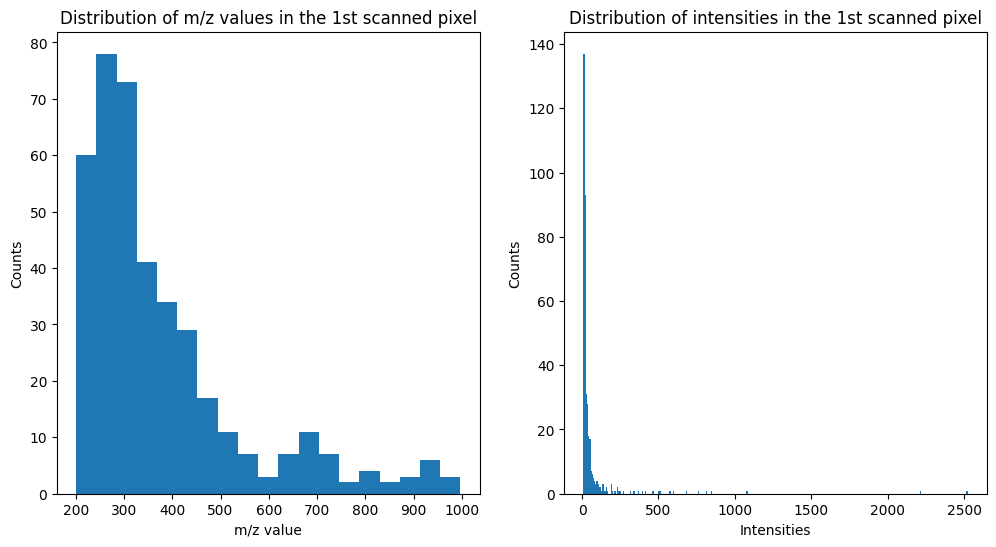

In [5]:
# Load the data from the .imzML file and extract some useful information
# Running this cell from a fresh kernel might show some warnings, but they can be ignored
from pyimzml.ImzMLParser import ImzMLParser

filename = 'A30.imzML'
parser = ImzMLParser(filename)

# Total number of coordinates where the spectra were collected
print(f'Spectra collected at a total of: {len(parser.coordinates)} coordinates')

# Number of unique x, y, z coordinates
x_coords = [coord[0] for coord in parser.coordinates]
y_coords = [coord[1] for coord in parser.coordinates]
z_coords = [coord[2] for coord in parser.coordinates]
print(f'\nUnique x-coordinates: {len(set(x_coords))}')
print(f'Unique y-coordinates: {len(set(y_coords))}')
print(f'Unique z-coordinates: {len(set(z_coords))}')

# Number of m/z values in the first spectrum and the range of m/z values
mz_values, intensities = parser.getspectrum(0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(mz_values, bins = 'auto')
axes[0].set_xlabel("m/z value")
axes[0].set_ylabel("Counts")
axes[0].set_title("Distribution of m/z values in the 1st scanned pixel")

axes[1].hist(intensities, bins = 'auto')
axes[1].set_xlabel("Intensities")
axes[1].set_ylabel("Counts")
axes[1].set_title("Distribution of intensities in the 1st scanned pixel")

mz_min, mz_max = min(mz_values), max(mz_values)
print(f'\nThe first spectrum contains {len(mz_values)} m/z values, ranging from {mz_min:.2f} to {mz_max:.2f}.')
print(f'Shapes of arrays. mz_values: {mz_values.shape} {intensities.shape}')

# Inspect the first few coordinates and their spectra
print("\nPreview of the first few spectra:")
for i, coords in enumerate(parser.coordinates):
    mz_values, intensities = parser.getspectrum(i)
    print(f"  Spectrum {i + 1}: Coordinates {coords}, Number of m/z values: {len(mz_values)}, Total intensity: {np.sum(intensities, axis = 0):.3f}, Mean intensity: {np.mean(intensities):.3f}")
    if i == 4:  # Limit to the first 5 spectra
        break

We now have a clearer understanding of the dataset: it represents a 2D image, of 94$\times$94 pixels, where each pixel is associated with spatial coordinates, a range of m/z values, and their corresponding intensity values. Next, we will focus on visualising and analysing this data to derive meaningful insights.

Let us begin by reconstructing the image from the data we have loaded from the `.imzML` file. To start, we will reconstruct a **Total Ion Current (TIC)** image. In this approach, we ignore the specific range of m/z values at each pixel and instead consider the sum of all intensity values at each pixel.

In [6]:
def reconstruct(file, ref_path=None):
    parser = ImzMLParser(file)
    x_coords = [coord[0] for coord in parser.coordinates]
    y_coords = [coord[1] for coord in parser.coordinates]

    # Determine image dimensions
    width, height = max(x_coords), max(y_coords)

    # Initialise the image array
    image = np.zeros((height, width))

    # Fill the image with total intensities
    for i, coordinate in enumerate(parser.coordinates):
        _, intensities = parser.getspectrum(i)
        total_intensity = sum(intensities) # Sum intensities
        x, y = coordinate[0] - 1, coordinate[1] - 1
        image[x, y] = total_intensity

    # Find the pixel with the highest intensity
    max_intensity = np.max(image)
    max_pixel = np.unravel_index(np.argmax(image), image.shape)  # Ensure correct (y, x) format
    print(f'Max intensity in image: {max_intensity} at pixel {max_pixel}')

    # Normalise the image for better visualisation
    image = (image / np.max(image)) * 255
    #image = image.astype(np.uint8)

    # Optionally include the reference optical image for comparison
    if ref_path:
        ref_img = mpimg.imread(ref_path)

        # Resize reference image if needed
        if ref_img.shape[:2] != image.shape[:2]:
            ref_img = resize(ref_img, (image.shape[0], image.shape[1]), anti_aliasing=True)

        ref_img = np.fliplr(ref_img) # Ensures that reference image matches the orientation of the MSI TIC image
        
        # Create figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Display reconstructed image with heat map
        im = axes[0].imshow(image, cmap='gray', origin='upper')  # Store imshow object
        axes[0].set_title('Reconstructed TIC Image')
        axes[0].set_xlabel('X Coordinate')
        axes[0].set_ylabel('Y Coordinate')

        # Display reference optical image
        axes[1].imshow(ref_img, cmap='gray', origin = 'upper')
        axes[1].set_title('Reference Optical Image')
        axes[1].set_xlabel('X Coordinate')
        axes[1].set_ylabel('Y Coordinate')

        # Add color bar (only for reconstructed image)
        cbar = fig.colorbar(im, ax=axes[0], orientation='vertical', fraction=0.05, pad=0.05)
        cbar.set_label('Normalised Total Intensity')

        plt.tight_layout()
        plt.savefig('MSI_TIC_image.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Display only the reconstructed image
    else:
        fig, ax = plt.subplots(figsize=(7, 6))
        im = ax.imshow(image, cmap='hot', origin='lower')  # Assign `imshow` object
        cbar = fig.colorbar(im, ax=ax, orientation='vertical')
        cbar.set_label('Total Intensity')

        ax.set_title('Reconstructed Total Ion Current (TIC) Image')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')

        plt.show()
    return image

Max intensity in image: 300044.8125 at pixel (np.int64(21), np.int64(39))


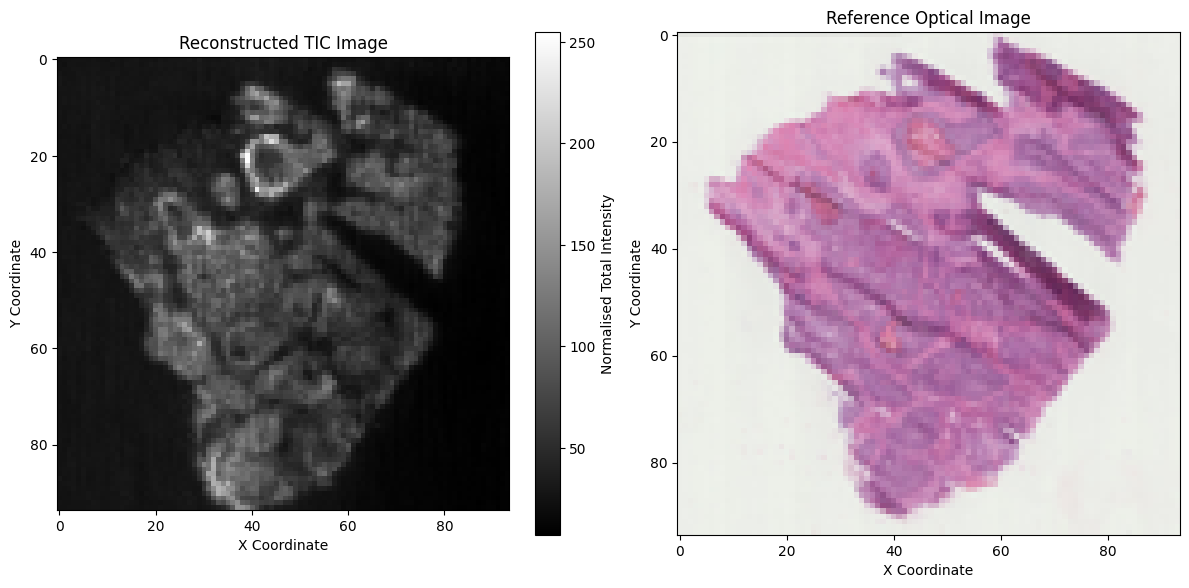

In [7]:
# Running this cell from a fresh kernel might show some warnings, but they can be ignored
MSI_image = reconstruct('A30.imzML', ref_path = 'A30_r.png')
np.save('MSI_image.npy', MSI_image)

As mentioned above, we summed the intensities for each pixel, disregarding their respective distributions of m/z values. We then normalised the total intensities by dividing them by the highest total intensity and scaling them to the range [0, 255], as is standard in image processing.

We selected a reference image with the same resolution as the reconstructed MSI TIC image to facilitate comparison. Upon inspection, we observe that the images align well, with their most prominent features matching. To ensure identical orientations, we have applied coordinate transformations to the reference image However, we note some discrepancies in the background regions of the two images, particularly in the number of pixels comprising these areas.

Now, we can use the ROIs from the previous section and the MSI image from this section to construct an ML model to perform image segmentation.

# Section 4: ML-based Biopsy Analysis

In this section, our goal is to use the MSI data as the features and the ROIs dataset as the targets for one or more ML models. The features dataset will serve as the input for making predictions, while the targets dataset contains the actual values against which we can assess the model’s performance.

There are two key issues we need to address moving forward:

- Shape mismatch: The ROI overlay has a shape of (100, 94), while the MSI data has a shape of (94, 94). To resolve this, we can apply transformations to scale one of the datasets so that both match in dimensions.
- Incomplete labelling: The ROI dataset only partially labels the image, leaving large regions unlabeled. While a histopathologist could manually assign labels to these regions, our ML model can only learn from the available data and make predictions based on the labels it has access to.

We must keep these considerations in mind when interpreting the results from our model(s).

Let us load back in the ROIs data and MSI data first:

In [8]:
rois = np.load('rois.npy')
msi_image = np.load('MSI_image.npy')

Now, we transform the MSI data to match the dimensions of the ROIs dataset. We use the `resize` function from the `skimage.transform` module.

In [9]:
from skimage.transform import resize

# Resize the ROIs to match the MSI image dimensions
rois_resized = resize(rois, (msi_image.shape[0], msi_image.shape[1]), order=0, preserve_range=True).astype(int)

Check the dimensions now:

In [10]:
print(f'Shape MSI image: {rois_resized.shape}')
print(f'Shape resized ROIs data: {msi_image.shape}')

Shape MSI image: (94, 94)
Shape resized ROIs data: (94, 94)


Let us now overlay the resized ROIs on the MSI image:

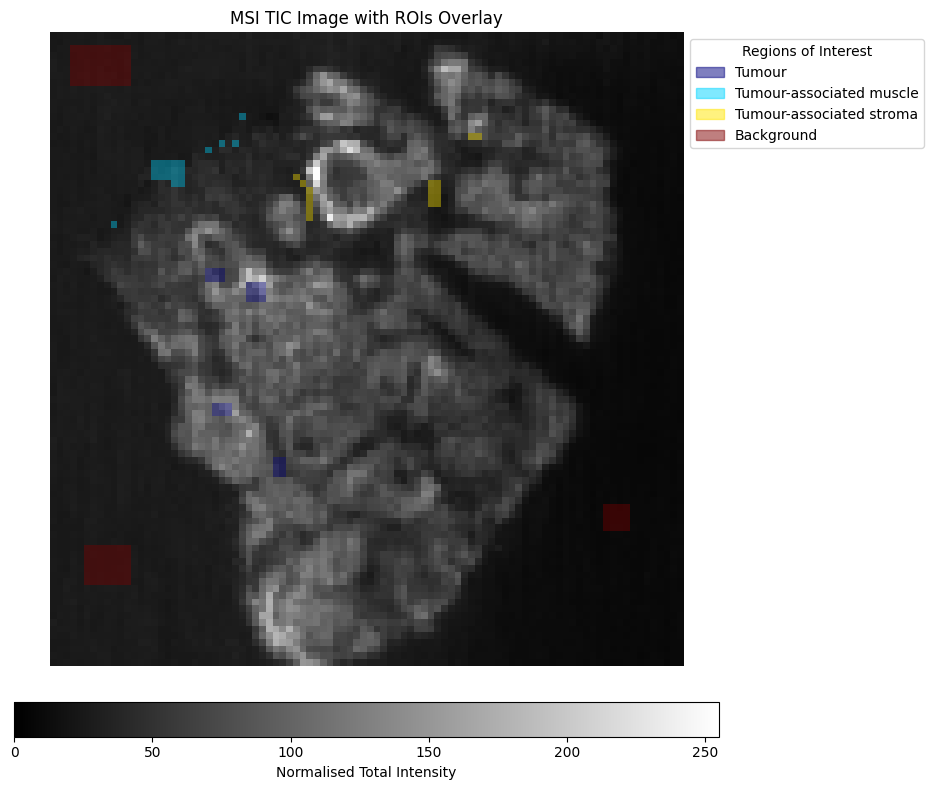

In [11]:
# Plotting the MSI image with ROIs overlay
fig, ax = plt.subplots(figsize=(10, 8))

# Display the MSI image
if msi_image.ndim == 3: # if image is RGB (3 channels of colour)
    ax.imshow(np.transpose(msi_image, (1, 2, 0)), cmap='gray')  # Transpose to (height, width, Channels)
else:  # If it's grayscale or single-channel
    ax.imshow(msi_image, cmap='gray')

# Mask non-region values in the ROI array (labelled 0s in ROIs dataset)
masked_rois = np.ma.masked_equal(rois_resized, 0)

im = ax.imshow(msi_image, cmap='gray', origin='lower')

# Overlay ROIs with transparency
ax.imshow(masked_rois, cmap='jet', alpha=0.4)  # Use 'jet' colormap; adjust alpha for visibility

# Extract unique regions for the legend
cmap = plt.colormaps['jet']
norm = plt.Normalize(vmin=np.min(rois_resized[rois_resized > 0]), vmax=np.max(rois_resized[rois_resized > 0]))  # Normalizing non-zero ROIs
colors = [cmap(norm(i)) for i in np.unique(rois_resized)[1:]]  # Skip '0' as it represents non-regions

# Define region labels (as found above)
regions = ['Tumour', 'Tumour-associated muscle', 'Tumour-associated stroma', 'Background']

# Create legend patches with transparency
patches = [mpatches.Patch(color=color, label=region, alpha=0.5) for color, region in zip(colors, regions)]

# Add legend
ax.legend(handles=patches, title="Regions of Interest", loc='upper left', bbox_to_anchor=(1, 1))
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05, pad=0.05)
cbar.set_label('Normalised Total Intensity')
cbar.mappable.set_clim(0, 255)  # Ensure correct colour scaling

# Title and display settings
plt.title("MSI TIC Image with ROIs Overlay")
plt.axis('off')
plt.tight_layout()

# Save and display the figure
plt.savefig('MSI_ROI_Overlay.png', dpi=300, bbox_inches='tight')
plt.show()

We now have a usable dataset for training and testing our ML models.

At this stage, we can take our analysis in two directions:

- Unsupervised techniques: These do not require ROIs for training; instead, ROIs can be used later to evaluate model performance. However, this approach often lacks interpretability.
- Supervised techniques: These use both ROIs and MSI data for training and testing. However, our dataset is not fully labelled, which presents a challenge.

We note that we have primarily used a TIC image so far, without considering the full distribution of m/z values for each pixel. This approach is not strictly necessary, and we can explore the complete m/z distributions, if we wish to do so. However, for now, we will stick to the TIC image from before.

## 4.1: Unsupervised ML Techniques

Let us begin by applying unsupervised ML techniques to the MSI image data. We will restrict ourselves to a few key methods:
- Principal Component Analysis (PCA)
- Uniform Manifold Approximation and Projection (UMAP)

We will not cover the mathematics of these techniques here, instead focusing on their implementation in our case. Let us return to the `.imzML` file and store all the spectral data in an array. We recall from earlier that the number of m/z values was not consistent across pixels (at least for the first five pixels) which presents an issue when trying to create an array from the data. To address this, we define a common grid of m/z values and interpolate the intensity values for each pixel onto this grid. We construct the grid by determining the global minimum and maximum m/z values across the entire dataset and then creating an evenly spaced set of m/z values. This ensures that all spectra have a consistent representation, making the dataset suitable for further analysis.

### 4.1.1 Preprocessing: Spectral Alignment

We found earlier that each pixel has a different number of m/z values, which can complicate our analysis since we would have to treat each pixel separately from its neighbours. However, we can work around this issue by selecting a common m/z grid that all spectra can be mapped to. We then interpolate the spectra of all pixels onto this common grid, ensuring that each spectrum has the same number of m/z bins and covers the same range of m/z values. After interpolation, we normalise the spectra (typically by TIC or another suitable method) to ensure all spectra are on the same scale. This process, called **spectral alignment**, allows us to treat all pixels on equal footing and analyse the entire sample as a whole.

Let us apply this procedure to our sample. We proceed in a few steps.

/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: Use

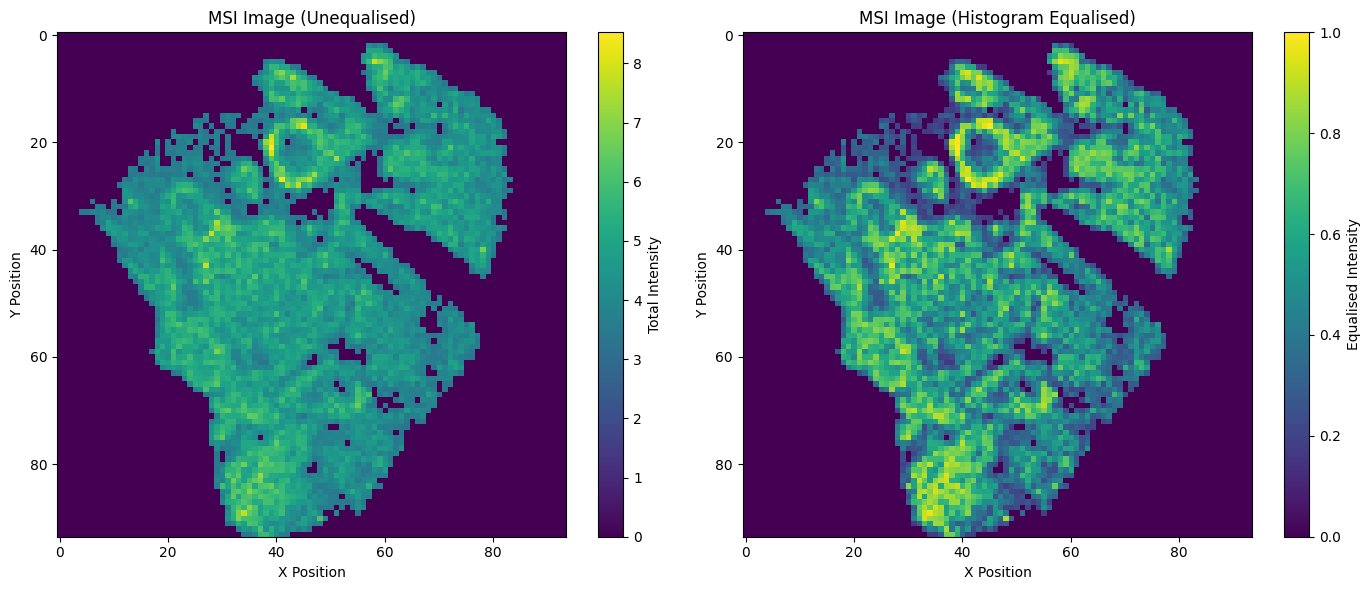

Interpolated and normalised spectra matrix shape: (8836, 1271)
Number of NaNs in spectra_matrix: 0


In [27]:
#### Step 1: Define Common Grid ####

import numpy as np
import matplotlib.pyplot as plt
from pyimzml.ImzMLParser import ImzMLParser
from scipy.interpolate import interp1d
from skimage import exposure

# Load the data
filename = 'A30.imzML'
parser = ImzMLParser(filename)

# Preload spectra to avoid repeated function calls
spectra = [parser.getspectrum(i) for i in range(len(parser.coordinates))]

# Find the maximum number of m/z values in any spectrum
max_mz_len = max(len(spectrum[0]) for spectrum in spectra)

# Collect all m/z values across spectra
all_mz_values = np.concatenate([spectrum[0] for spectrum in spectra])

# Define the m/z grid (simple linear binning here)
min_mz = np.min(all_mz_values)
max_mz = np.max(all_mz_values)

# Linear grid based on maximum number of m/z values in any spectrum
common_mz_grid = np.linspace(min_mz, max_mz, max_mz_len)

#### Step 2: Interpolating onto Common Grid ####

# Initialise the matrix to store interpolated spectra
spectra_matrix = np.zeros((len(parser.coordinates), max_mz_len))

# Interpolate spectra onto the common m/z grid
for i in range(len(parser.coordinates)):
    mz_values, intensities = parser.getspectrum(i)

    if len(mz_values) == 0:
        continue  # Skip empty spectra

    # Interpolate intensities onto the common m/z grid
    interp_func = interp1d(mz_values, intensities, kind='linear', bounds_error=False, fill_value=np.median(intensities))
    spectra_matrix[i, :] = interp_func(common_mz_grid)

#### Step 3: Normalisation and Background Masking ####

# Calculate TIC for each pixel
tic_values = np.sum(spectra_matrix, axis=1)  # Sum intensities across all m/z bins for each spectrum

# Define a threshold for masking the background
threshold = np.max(tic_values) * 0.39  # Keep pixels with top 39% of TIC values

# Create a binary mask: True for pixels above the threshold, False for background
mask = tic_values > threshold

# Mask the background by setting intensities to a small value
background_value = 0
spectra_matrix_filtered = spectra_matrix.copy()
spectra_matrix_filtered[~mask, :] = background_value  # Apply masking

# Normalise the entire matrix by global TIC max after masking
global_max_tic = np.max(spectra_matrix_filtered)  # Find max TIC after masking
spectra_matrix_filtered /= global_max_tic  # Normalise the spectra matrix

# Sum the intensities across all m/z bins (this gives the total intensity per pixel)
total_intensity = np.sum(spectra_matrix_filtered, axis=1)

# Normalise total intensity between 0 and 1
total_intensity_normalised = (total_intensity - np.min(total_intensity)) / (np.max(total_intensity) - np.min(total_intensity))

# Apply adaptive histogram equalisation (better contrast between pixels)
total_intensity_equalised = exposure.equalize_adapthist(total_intensity_normalised)

# Reshape images for visualization
image_unequalised = total_intensity.reshape(int(np.sqrt(len(parser.coordinates))),
                                            int(np.sqrt(len(parser.coordinates))), order='F')

image_equalised = total_intensity_equalised.reshape(int(np.sqrt(len(parser.coordinates))),
                                                    int(np.sqrt(len(parser.coordinates))), order='F')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Unequalised image
ax = axes[0]
im = ax.imshow(image_unequalised, cmap='viridis', aspect='auto', interpolation='none')
fig.colorbar(im, ax=ax, label='Total Intensity')
ax.set_title("MSI Image (Unequalised)")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")

# Equalised image
ax = axes[1]
im = ax.imshow(image_equalised, cmap='viridis', aspect='auto', interpolation='none')
fig.colorbar(im, ax=ax, label='Equalised Intensity')
ax.set_title("MSI Image (Histogram Equalised)")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")

# Show the figure
plt.tight_layout()
plt.show()

# Verify results
print(f"Interpolated and normalised spectra matrix shape: {spectra_matrix_filtered.shape}")
print(f"Number of NaNs in spectra_matrix: {np.isnan(spectra_matrix_filtered).sum()}")

## histogram-equalisation seems quite comparable to log median-fold transform that we use widely in the field (https://pubmed.ncbi.nlm.nih.gov/21526840/), effectively it stabilises the variances before e.g., PCA

### 4.1.2 Principal Component Analysis (PCA)

We begin by implementing the PCA algorithm to identify the components that represent the most significant variations in the MSI TIC image. PCA is an effective and efficient method that decomposes the data into principal components (PCs), which capture the largest sources of variance in the data. These components are linear combinations of the original features, and by retaining the most important components, PCA allows for dimensionality reduction while preserving the essential patterns in the data.

One limitation of PCA is that it assumes the data follows linear relationships. This means that non-linear patterns in the data might not be captured well by PCA, potentially leading to a loss of important information. However, PCA is a powerful tool for uncovering the main structure in the data and is widely used in MSI.

We will first check the number of components required to explain around 90%-95% of the variance in the data. First we apply PCA with an arbitrary number of PCs to find the explained variance ratio for the fit:

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

#spectra_matrix_log = np.log1p(spectra_matrix_filtered)

# Apply min-max scaling if using PCA for visualisation
minmax_scaler = MinMaxScaler()
spectra_matrix_scaled = minmax_scaler.fit_transform(spectra_matrix_filtered)

# Fit PCA without specifying components to capture full variance
pca_full = PCA()
pca_full.fit(spectra_matrix_scaled)

# Compute cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Select the number of PCs that explain at least 95% variance
num_pcs = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of PCs to retain 95% variance: {num_pcs}")

# Apply PCA with the chosen number of components
pca = PCA(n_components=num_pcs)
pca_result = pca.fit_transform(spectra_matrix_scaled)

Optimal number of PCs to retain 95% variance: 222


Let us visualise how the ratio varies with increasing number of PCs:

Total explained variance by 222 components: 0.9494219403754699


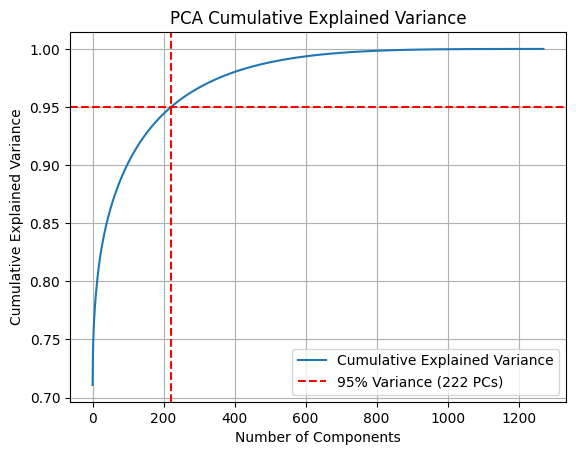

In [32]:
# Print the actual explained variance
print(f"Total explained variance by {num_pcs} components: {np.sum(pca.explained_variance_ratio_)}")

# Visualize cumulative explained variance
plt.plot(cumulative_variance, label='Cumulative Explained Variance')
plt.axvline(x=num_pcs, color='r', linestyle='--', label=f'95% Variance ({num_pcs} PCs)')
plt.axhline(y = 0.95, color = 'r', linestyle = '--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid()
plt.title('PCA Cumulative Explained Variance')
plt.show()

We find that there are diminishing returns on the amount of variance explained as the number of PCs is increased (which is somewhat expected).

Next, we need to extract three key pieces of information from the PCA analysis:

- The reconstructed PC images of the MSI data, which represent spatial patterns of variability in the dataset. Each reconstructed PC image highlights different regions of intensity variation based on the corresponding principal component.
- The contributions of different m/z values to each principal component, which indicate which m/z values are most influential in defining each PC. This helps in understanding the spectral features driving the variability in the MSI data.
- The explained variance ratio of each PC, which gives the fraction of variance captured by a given PC.

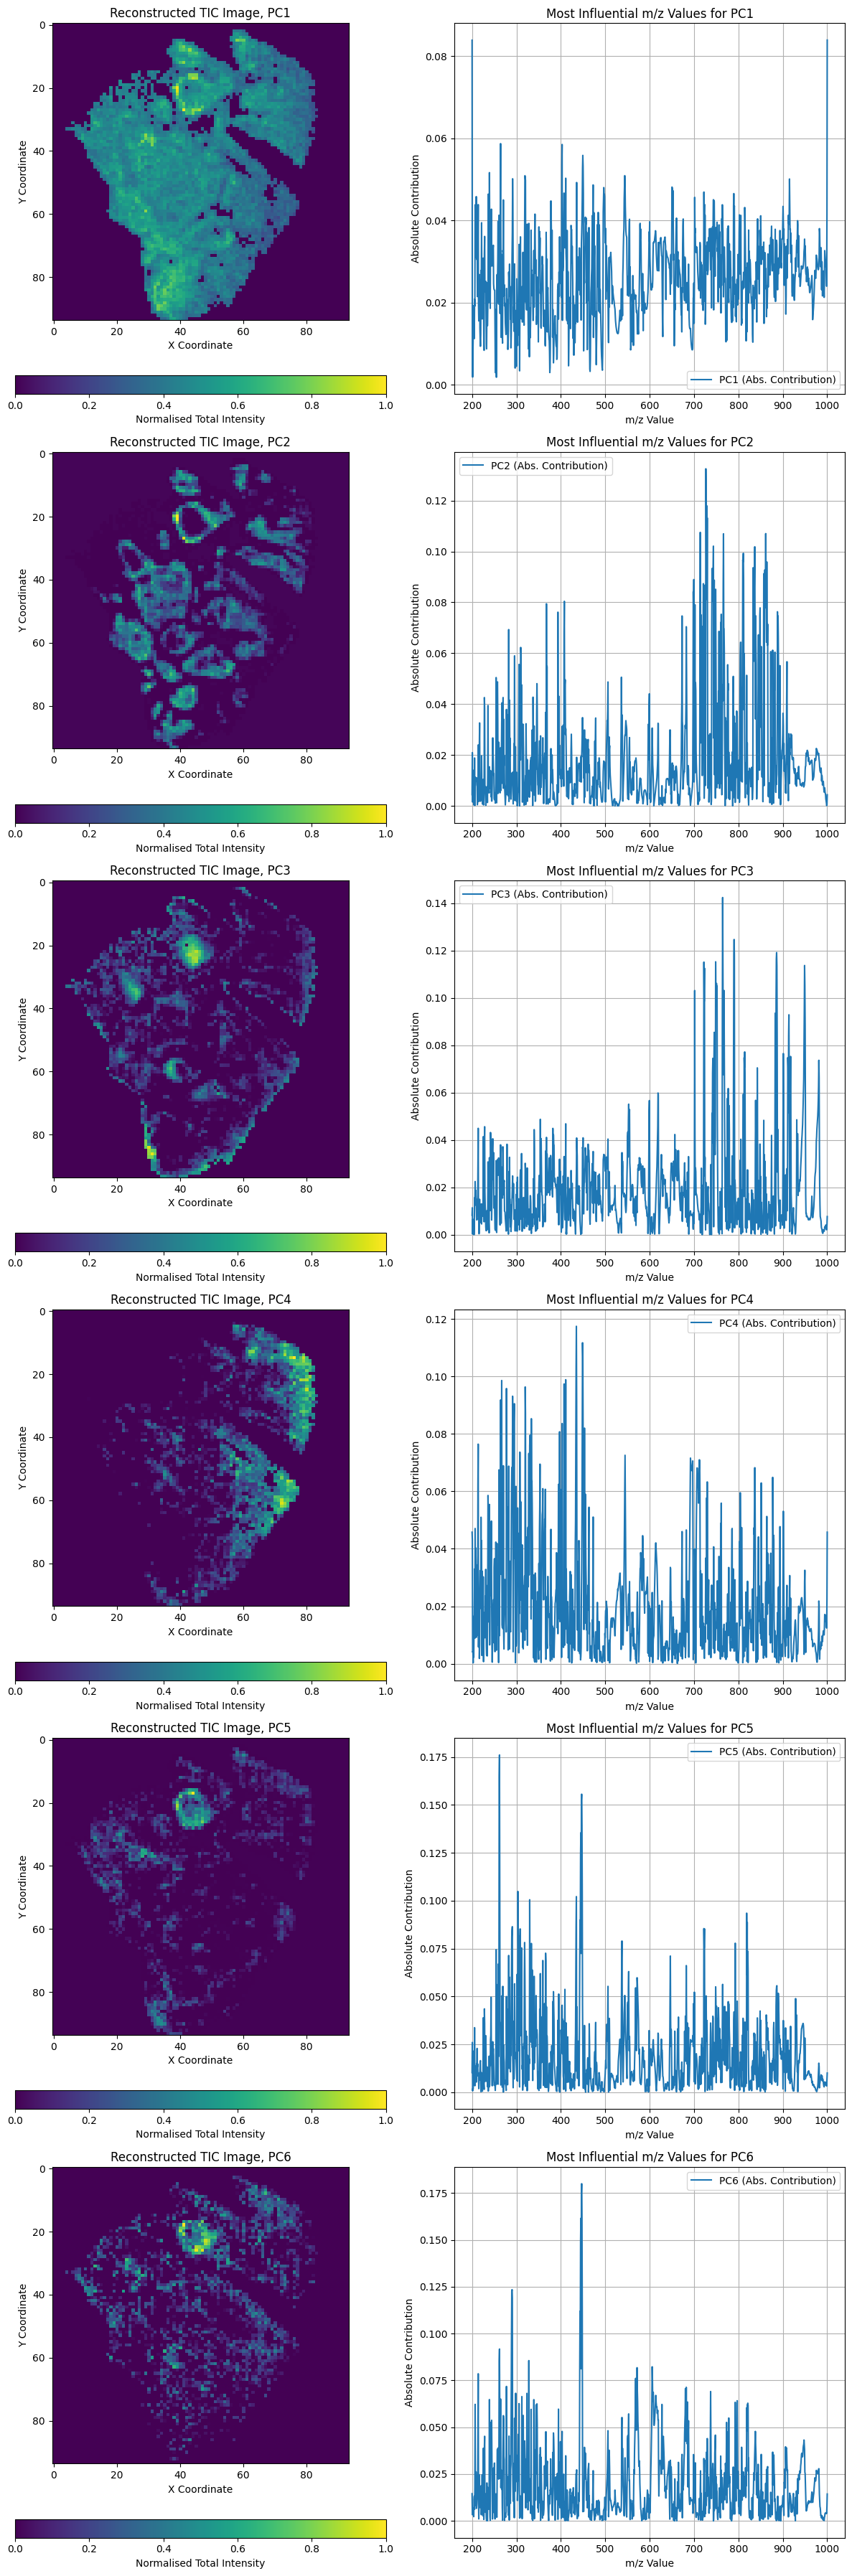

In [33]:
# Compute absolute contributions of each PC
abs_coefficients = np.abs(pca.components_)

# Visualize the first 6 PCs
num_pcs_plot = min(6, len(pca.components_))
fig, axes = plt.subplots(num_pcs_plot, 2, figsize=(12, 6*num_pcs_plot))  # One row per PC

for i in range(num_pcs_plot):  # Use num_pcs_plot to determine how many PCs to visualize
    # Reconstruct the image using only the i-th principal component
    reconstructed_spectra = np.outer(pca_result[:, i], pca.components_[i])  # Outer product for rank-1 reconstruction

    # Sum across m/z values to get a 1D intensity value per pixel
    reconstructed_intensities = np.sum(reconstructed_spectra, axis=1)

    # Ensure reshaping is valid (assuming msi_image is a 2D array)
    if 'msi_image' in locals():
        assert spectra_matrix.shape[0] == np.prod(msi_image.shape[:2]), "Mismatch between spectra and image dimensions!"
    
    # Reshape back into the MSI image grid
    reconstructed_image = reconstructed_intensities.reshape(msi_image.shape[:2], order='F')  # Ensure correct reshaping

    # Normalize the current PC's image individually
    reconstructed_image /= np.max(np.abs(reconstructed_image)) + 1e-16  # Normalization per PC
    
    # Display the reconstructed image for PC i
    im = axes[i, 0].imshow(reconstructed_image, cmap='viridis', origin='upper')
    axes[i, 0].set_title(f'Reconstructed TIC Image, PC{i+1}')
    axes[i, 0].set_xlabel('X Coordinate')
    axes[i, 0].set_ylabel('Y Coordinate')
    
    # Plot the most influential m/z values for PC i
    axes[i, 1].plot(common_mz_grid, abs_coefficients[i], label=f"PC{i+1} (Abs. Contribution)")
    axes[i, 1].set_title(f"Most Influential m/z Values for PC{i+1}")
    axes[i, 1].set_xlabel("m/z Value")
    axes[i, 1].set_ylabel("Absolute Contribution")
    axes[i, 1].grid(True)
    axes[i, 1].legend()
    
    # Add colour bar
    cbar = fig.colorbar(im, ax=axes[i, 0], orientation='horizontal', fraction=0.05, pad=0.15)
    cbar.set_label('Normalised Total Intensity')
    cbar.mappable.set_clim(0, 1)  # Ensure consistent scaling across all PCs

plt.tight_layout()
plt.savefig('PC_Contributions_Individual_Normalization.png', dpi=300, bbox_inches='tight')  # Save full figure
plt.show()

From the PCA results, we find that the first principal component (PC1) explains approximately 37.5% of the variance in the data, making it the most dominant source of variation. The second principal component (PC2) captures around 11.4% of the variance, while the third principal component (PC3) accounts for 10.4%, and so forth. This indicates that PC1 primarily captures the strongest variance patterns in the dataset, with subsequent components representing progressively smaller variations.

Together, the first four PCs explain approximately 65% of the total variance, meaning that around 35% of the variance remains unaccounted for by these components. This is expected, as MSI data is highly complex and often exhibits non-linear patterns, whereas PCA is a linear dimensionality reduction technique.

Notably, PC1 effectively separates the sample from the background, indicating that the dominant variance is driven by the presence of biological material. PC2 further distinguishes between tumour and tumour-associated regions, suggesting distinct biochemical or structural differences. Higher-order PCs, on the other hand, appear to capture instrumental noise rather than meaningful variance that was missed by the lower-order components. However, their potential relevance can be further assessed by examining their loadings. The loadings are presented on the right-hand side, and the m/z values contributing to each PC can be checked against a reference database to explore whether biologically significant insights can be derived from the higher-order PCs.

### 4.1.2 Uniform Manifold Approximation and Projection (UMAP)

Let us now implement a nonlinear dimensionality reduction technique: UMAP. Unlike PCA, which produces principal components as linear combinations of the original features, UMAP creates a low-dimensional embedding that captures the structure of the high-dimensional data. This embedding preserves local and global relationships more effectively than PCA, making it particularly useful for capturing complex, nonlinear patterns in the data.

In [ ]:
from umap import UMAP

TIC = np.sum(spectra_matrix, axis=1)  # Sum intensities for each pixel across m/z values

# Apply UMAP
umap = UMAP(n_components = 3, n_neighbors = 10, min_dist = 0.1, metric = 'euclidean') 
umap_result = umap.fit_transform(spectra_matrix)

num_pcs = umap_result.shape[1]  # Should be 3

## how are the hyperparameters optimised?

We can also visualise these embeddings in a 3D space:

In [ ]:
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

# Normalize the TIC values between 0 and 1
scaler = MinMaxScaler()
TIC_normalised = scaler.fit_transform(TIC.reshape(-1, 1)).flatten()

# Create a 3D scatter plot using Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=umap_result[:, 0],
    y=umap_result[:, 1],
    z=umap_result[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=TIC_normalised,  # Use the normalised TIC values
        colorscale='jet',
        colorbar=dict(title='Normalised TIC'),
    )
)])

# Update layout for labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        zaxis_title='UMAP Component 3',
    ),
    title='UMAP 3D Embedding',
    width=1000,
    height=800,
)

# Show the interactive plot
fig.show()
fig.write_html("UMAP_3D_Embedding.html")

We can create similarity maps where spectral similarity between pixels, quantified by their proximity in high-dimensional space, is visualised through colour similarity.

In [ ]:
from scipy.spatial.distance import cdist

# Step 1: Compute a reference embedding
threshold = np.percentile(TIC, 1) # Select pixels in the lowest 1% of TIC values
low_TIC_indices = np.where(TIC <= threshold)[0]
reference_point = np.mean(umap_result[low_TIC_indices], axis=0)

# Or find pixel with lowest TIC
# background_pixel_idx = np.argmin(TIC)  
# reference_point = umap_result[background_pixel_idx]

# Step 2: Compute Euclidean distance for each pixel from reference
distances = cdist(umap_result, reference_point.reshape(1, -1), metric = 'euclidean').flatten()

# Step 3: Reshape distances into MSI image shape (first two dimensions only, since a colour channel could be included generally)
distance_map = distances.reshape(msi_image.shape[:2], order='F')

# Step 4: Normalize the distance map
distance_map = (distance_map - np.min(distance_map)) / (np.max(distance_map) - np.min(distance_map))

# Step 5: Plot the distance map
plt.figure(figsize=(8, 6))
plt.imshow(distance_map, cmap='inferno', origin='upper')  # Adjust origin if needed
plt.colorbar(label='Normalised Distance')
plt.title('Similarity Map from Mean UMAP Embedding')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

We find that this method enables the "digital staining" of the sample via a similarity map (or a distance map, comparing the sample to the background). This allows us to identify regions of interest (ROIs) based on their "closeness" in the 3D UMAP embedding of the high-dimensional space derived from our original dataset. However, the staining produced does not provide discrete boundaries between the various ROIs. Instead, it offers a measure of how closely the pixels "resemble" one another based on the m/z and intensity data they contain.

### 4.1.3 PCA + UMAP
We can combine PCA and UMAP to more effectively reduce noise in the data while retaining the most important sources of variance. PCA first removes redundant information and highlights key patterns, and UMAP then captures nonlinear relationships, enhancing the interpretability of the results.

## there is an option to initialise UMAP with PCA

In [35]:
TIC = np.sum(spectra_matrix, axis=1)  # Sum intensities for each pixel across m/z values

# Step 1: Apply PCA for initial dimensionality reduction
pca = PCA(n_components = 30)  # Start with enough components to capture 95% of the variance in the data
pca_result = pca.fit_transform(spectra_matrix)

# Explained variance ratios of each PC and total explained variance (useful if a specified number of components is used)
num_pcs = len(pca.components_)
explained_variance_str = ', '.join([f"{ratio:.3f}" for ratio in pca.explained_variance_ratio_])
total_variance = np.sum(pca.explained_variance_ratio_) * 100  # Total explained variance in percentage
# print(f'The explained variance ratio for the first {num_pcs} components is: [{explained_variance_str}], \
# explaining a total of {total_variance:.2f}% of the variance in the data.')

# Step 2: Apply UMAP on PCA-reduced data
umap_reducer = UMAP(n_components = 3, n_neighbors = 10, min_dist = 0.1, metric = 'euclidean')
umap_pca_result = umap_reducer.fit_transform(pca_result)

# Step 3: Extract UMAP embeddings
num_umap_pca_components = umap_pca_result.shape[1]

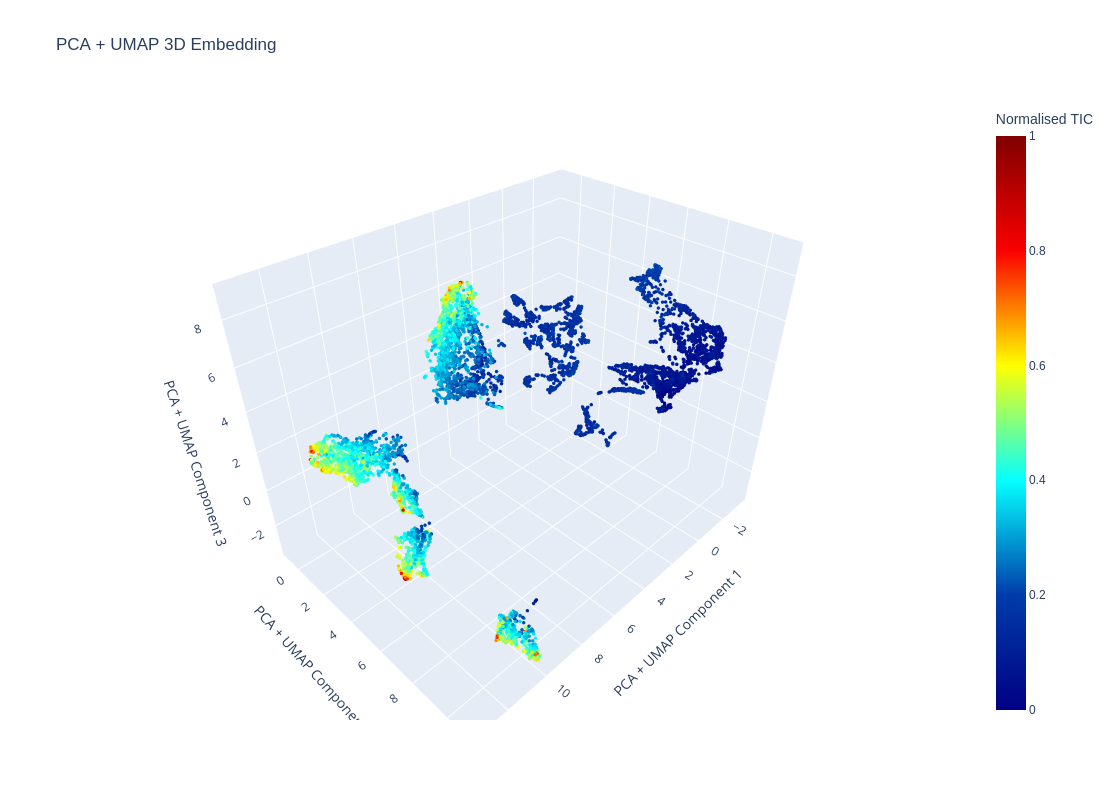

In [38]:
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

# Normalize TIC values between 0 and 1 for better visualization
scaler = MinMaxScaler()
TIC_normalised = scaler.fit_transform(TIC.reshape(-1, 1)).flatten()

# Create a 3D scatter plot using Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=umap_pca_result[:, 0],
    y=umap_pca_result[:, 1],
    z=umap_pca_result[:, 2],
    mode='markers',
    marker=dict(
        size=2,  # Increase marker size for better visibility
        color=TIC_normalised,  # Use normalised TIC values
        colorscale='jet',
        colorbar=dict(title='Normalised TIC'),
    )
)])

# Update layout for labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='PCA + UMAP Component 1',
        yaxis_title='PCA + UMAP Component 2',
        zaxis_title='PCA + UMAP Component 3',
    ),
    title='PCA + UMAP 3D Embedding',
    width=1000,
    height=800,
)

# Show the interactive plot
fig.show()
fig.write_html("UMAP_PCA_3D_Embedding.html")

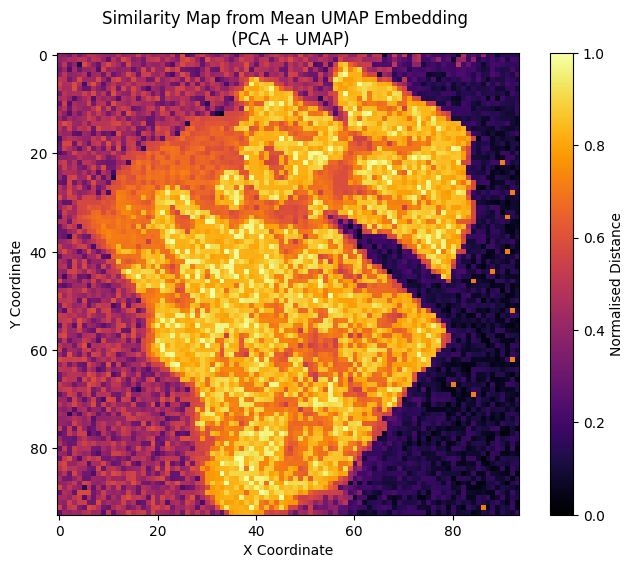

In [39]:
from scipy.spatial.distance import cdist

# Step 1: Compute a reference embedding
threshold = np.percentile(TIC, 1) # Select pixels in the lowest 1% of TIC values
low_TIC_indices = np.where(TIC <= threshold)[0]
reference_point = np.mean(umap_pca_result[low_TIC_indices], axis=0)

# Or find pixel with lowest TIC
# background_pixel_idx = np.argmin(TIC)  
# reference_point = umap_pca_result[background_pixel_idx]

# Step 2: Compute Euclidean distance for each pixel from reference
distances = cdist(umap_pca_result, reference_point.reshape(1, -1), metric = 'euclidean').flatten()

# Step 3: Reshape distances into MSI image shape
distance_map = distances.reshape(msi_image.shape, order = 'F')  # Ensure correct reshaping order

# Step 4: Normalize the distance map
distance_map = (distance_map - np.min(distance_map)) / (np.max(distance_map) - np.min(distance_map))

# Step 5: Plot the distance map
plt.figure(figsize = (8, 6))
plt.imshow(distance_map, cmap = 'inferno', origin = 'upper')  # Adjust origin if needed
plt.colorbar(label='Normalised Distance')
plt.title('Similarity Map from Mean UMAP Embedding \n (PCA + UMAP)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

As before, we have digitally stained the sample, however this time, we have managed to provide a greater degree of distinction between Tumour and Tumour-associated regions, at the cost of distinctions within the Tumour ROI.

## here it would be interesting to look at the embedding from UMAP and do clustering (see https://umap-learn.readthedocs.io/en/latest/clustering.html), and use the clustering results for segmentation of the data to see if it matches the pathology classes (*remember to apply the tissue mask first)

# 4.2: Supervised ML Techniques

We can also apply supervised techniques to analyse the sample and classify its various regions. We will implement various supervised ML models and train and test our model on the labelled areas of the image. Then, we will try to assign labels to the rest of the image to see how well our model performs.

First, let us look more closely at the data. We focus on the number of pixels that belong to each class in our dataset. As a reminder, the classes are [0 1 2 3 4], corresponding to 'Non-Region', 'Tumour', 'Tumour Associated Muscle', 'Tumour Associated Stroma', and 'Background'.

We will count the number of Non-region pixels in the data for completeness but will filter them out in our discussion going forward. We will later use our trained supervised ML model to label these non-regions and check how well our predictions match up with pathology.

In [21]:
unique_labels, counts = np.unique(rois, return_counts=True)

for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} pixels")

Class 0.0: 9204 pixels
Class 1.0: 33 pixels
Class 2.0: 22 pixels
Class 3.0: 20 pixels
Class 4.0: 121 pixels


We will now process the data for supervised machine learning models, beginning with the Support Vector Machine Classifier (SVC). SVC is an efficient algorithm that performs well on linearly separable data and is relatively fast to train.

As a preprocessing step, we apply Principal Component Analysis (PCA) to reduce the dataset’s dimensionality. This offers several advantages:

- Faster training and testing by reducing computational complexity.
- Noise reduction, preventing the model from learning irrelevant variations in the data.
- Improved separability, as PCA has already demonstrated its ability to distinguish between sample and background regions, as well as between tumour and tumour-associated areas.

Since PCA produces linearly separated components, it is particularly well-suited for SVC, which relies on finding optimal decision boundaries in a transformed feature space. Additionally, we note that SVC requires standardised features to perform effectively.

First we load in the data in the `.imzML` file and process it as we did previously:

In [22]:
# Pre-processing repeated from Section 3

filename = 'A30.imzML'
parser = ImzMLParser(filename)

# Find global min and max m/z values across all spectra
mz_min, mz_max = None, None

for i in range(len(parser.coordinates)):
    mz_values, _ = parser.getspectrum(i)
    if mz_values.size > 0:
        if mz_min is None or mz_max is None:
            mz_min, mz_max = np.min(mz_values), np.max(mz_values)
        else:
            mz_min = min(mz_min, np.min(mz_values))
            mz_max = max(mz_max, np.max(mz_values))

# Ensure we found at least one valid spectrum
if mz_min is None or mz_max is None:
    raise ValueError("No valid spectra found in the dataset.")

print(f"Global m/z range: {mz_min:.2f} to {mz_max:.2f}")

# Define a common m/z grid
mz_resolution = 0.1  # Adjust based on instrument resolution
num_bins = max(2, int((mz_max - mz_min) / mz_resolution))  # Ensure at least 2 bins
mz_grid = np.linspace(mz_min, mz_max, num_bins)

# Preallocate spectra matrix
spectra_matrix = np.full((len(parser.coordinates), num_bins), fill_value=np.nan)

for i in range(len(parser.coordinates)):
    mz_values, intensities = parser.getspectrum(i)
    
    if mz_values.size == 0:
        print(f"Warning: Empty spectrum at index {i}, skipping.")
        continue

    # Handle duplicate m/z values
    mz_values, unique_indices = np.unique(mz_values, return_index=True)
    intensities = intensities[unique_indices]

    # Interpolate onto common grid
    interp_func = interp1d(mz_values, intensities, kind='linear', bounds_error=False, fill_value=0)
    spectra_matrix[i, :] = interp_func(mz_grid)

print(f"Interpolated spectra matrix shape: {spectra_matrix.shape}")

/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning:

Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".

/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning:

Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".

/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning:

Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".

/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning:

Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".

/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning:

Accession IMS

Global m/z range: 200.03 to 1000.14
Interpolated spectra matrix shape: (8836, 8001)


In [ ]:
# New pre-processing for Supervised ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Now, we associate the spectra with the labels
rois_resized = resize(rois, (msi_image.shape[0], msi_image.shape[1]), order = 3, preserve_range=True) # Resize ROIs to match MSI image shape
rois_flat = rois_resized.reshape(-1).astype(int)  # Flatten ROIs labels

# Create a mask to exclude non-region pixels (where ROI == 0)
mask = rois_flat != 0  

# Run PCA for dimensionality reduction
# Use enough components to capture 95% of the variance in the data
pca = PCA(n_components = 0.95)
spectra_matrix_pca = pca.fit_transform(spectra_matrix)

# Apply the mask to filter out background pixels
spectra_filtered = spectra_matrix_pca[mask]  # Filtered spectra matrix
rois_filtered = rois_flat[mask]          # Filtered ROIs (labels)
print(f'Original spectral matrix shape: {spectra_matrix.shape}')
print(f'Reduced spectral matrix shape: {spectra_filtered.shape}')

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(spectra_filtered, rois_filtered, 
                                                    test_size = 0.2, stratify = rois_filtered, 
                                                    random_state=42)

# Scale features (Standardisation); useful for SVC
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'C': 1, 'class_weight': 'balanced', 'coef0': 0, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True, 'tol': 0.001}
              precision    recall  f1-score   support

           1       0.70      0.70      0.70        10
           2       1.00      0.25      0.40         4
           3       0.38      0.50      0.43        10
           4       0.46      0.46      0.46        13

    accuracy                           0.51        37
   macro avg       0.64      0.48      0.50        37
weighted avg       0.56      0.51      0.51        37



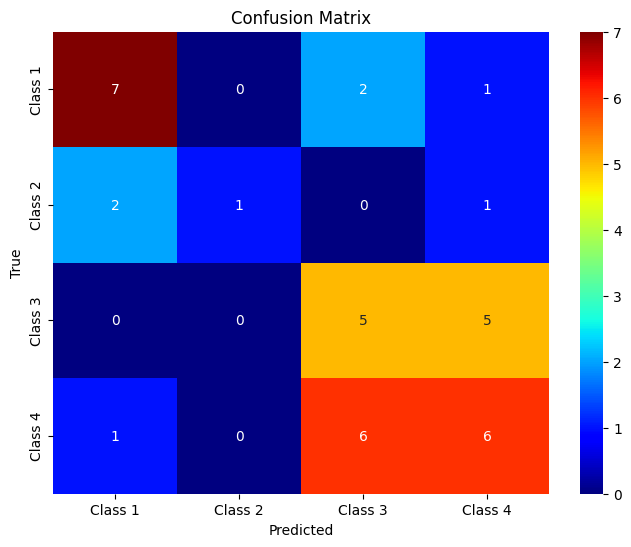

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define parameter grid
param_grid_svc = {
    'C': [0.1, 1, 10],  # Reduced values for regularization strength
    'kernel': ['linear', 'rbf'],  # Linear and RBF kernels are typically the most common
    'gamma': ['scale', 'auto'],  # Keep only scale and auto as common gamma values
    'class_weight': ['balanced'],  # You could stick to 'balanced' as it's useful for imbalanced classes
    'degree': [2],  # Degree is only relevant for 'poly' kernel, so keeping it to the default value for now
    'coef0': [0],  # Default value for poly and sigmoid kernels (you can expand later if needed)
    'shrinking': [True],  # Shrinking heuristic is often useful, so keep it simple
    'tol': [1e-3],  # Default tolerance value
}

# Initialize SVC model
svc_model = SVC()

# Set up GridSearchCV
grid_search_svc = GridSearchCV(svc_model, param_grid_svc, cv = 5, scoring = 'f1_weighted', n_jobs = 6, verbose = 1)

# Fit grid search
grid_search_svc.fit(X_train_scaled, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search_svc.best_params_)

# Evaluate the best model
y_pred = grid_search_svc.best_estimator_.predict(X_test_scaled)

# Print the classification report
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="jet", xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'], 
            yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()